In [2]:
!pip install tensorflow-model-optimization

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
import itertools
from datetime import datetime
import tensorflow as tf
import seaborn as sns
import tempfile
import tensorflow_model_optimization as tfmot
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the ECG data from drive**

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Work/ECG-sudhanshu/mitbih_train.csv', header=None)
test = pd.read_csv('/content/drive/MyDrive/Work/ECG-sudhanshu/mitbih_test.csv', header=None)
X_train, y_train = train.iloc[:, :187], train[187]
X_test, y_test = test.iloc[:, :187], test[187]

In [7]:
## Printing the training and testing shape
print(X_train.shape, X_test.shape)

(87554, 187) (21892, 187)


In [8]:
'''(*2-1) is used to normalize the dataset into the range (-1,1)'''

no_classes =5

# Parse numbers as floats
input_train = X_train.astype('float32')*2-1
input_test = X_test.astype('float32')*2-1


# Convert target vectors to categorical targets
target_train = tf.keras.utils.to_categorical(y_train, no_classes)
target_test = tf.keras.utils.to_categorical(y_test, no_classes)

**Model configuration**

In [9]:

batch_size = 200
n_epochs = 50
n_classes = 5
validation_split = 0.3
verbosity = 1

**ECONet model baesd on 1D-CNN**

In [10]:

def ECONet(n_classes):
    model = tf.keras.Sequential([
        # Layer 1
        tf.keras.layers.Conv1D(filters=128, kernel_size=80, strides=4, padding='same', input_shape=(187, 1)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),  # Adjusted kernel size and stride
        # Layer 2
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),  # Adjusted kernel size and stride
        tf.keras.layers.Dropout(rate=0.2),
        # Layer 3
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),  # Adjusted kernel size and stride
        # Layer 4
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),  # Adjusted kernel size and stride
        tf.keras.layers.Dropout(rate=0.3),
        # Output layer
        tf.keras.layers.GlobalAveragePooling1D(),  # AdaptiveAvgPool1d equivalent
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(no_classes),
        tf.keras.layers.Softmax(axis=1)
    ])
    return model




In [11]:
# Create an instance of the ECGNet model
n_classes = 5  # Change this according to your problem
model = ECONet(no_classes)

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 47, 128)           10368     
                                                                 
 re_lu (ReLU)                (None, 47, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 128)           49280     
                                                                 
 re_lu_1 (ReLU)              (None, 24, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 12, 128)           0         
 g1D)                                                   

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [13]:
# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
history=model.fit(input_train, target_train,
          batch_size=batch_size,
          epochs=n_epochs,
          verbose=verbosity,
          validation_data=(input_test, target_test),
          callbacks = [learning_rate_reduction])


Epoch 1/50
438/438 [==============================] - 27s 10ms/step - loss: 0.3898 - accuracy: 0.8956 - val_loss: 0.1981 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 2/50
438/438 [==============================] - 5s 11ms/step - loss: 0.1779 - accuracy: 0.9531 - val_loss: 0.1343 - val_accuracy: 0.9651 - lr: 0.0010
Epoch 3/50
438/438 [==============================] - 7s 15ms/step - loss: 0.1349 - accuracy: 0.9647 - val_loss: 0.1134 - val_accuracy: 0.9697 - lr: 0.0010
Epoch 4/50
438/438 [==============================] - 5s 12ms/step - loss: 0.1156 - accuracy: 0.9690 - val_loss: 0.0973 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/50
438/438 [==============================] - 3s 7ms/step - loss: 0.1021 - accuracy: 0.9724 - val_loss: 0.0907 - val_accuracy: 0.9749 - lr: 0.0010
Epoch 6/50
438/438 [==============================] - 4s 10ms/step - loss: 0.0935 - accuracy: 0.9740 - val_loss: 0.1003 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 7/50
438/438 [==============================] - 6s 14ms/st

In [15]:
print("Accuracy of the model is - " , model.evaluate(input_test, target_test)[1]*100 , "%")

685/685 [==============================] - 3s 3ms/step - loss: 0.0601 - accuracy: 0.9847
Accuracy of the model is -  98.46519231796265 %


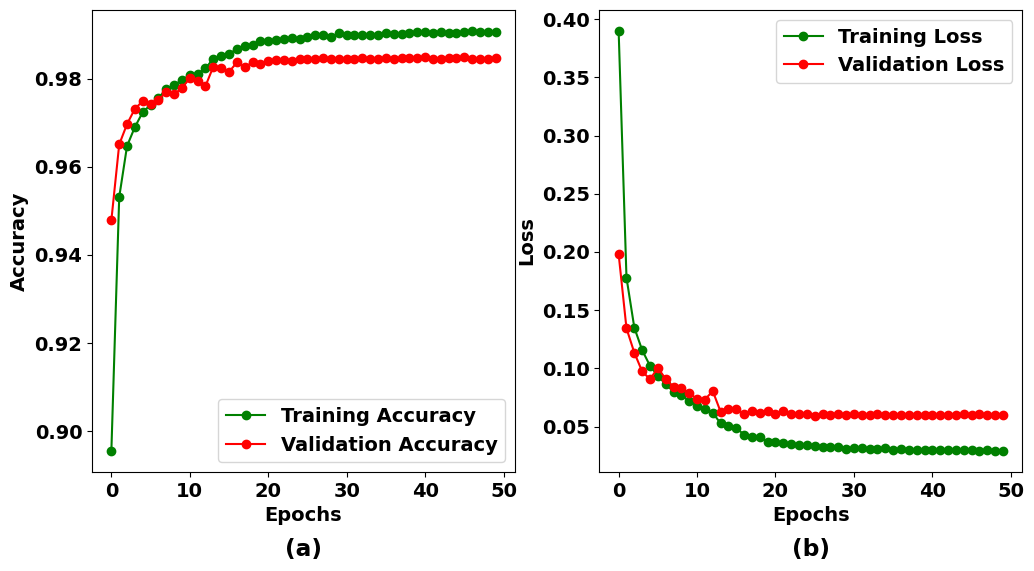

In [16]:
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'
rcParams.update({'font.size': 14})

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(12,6)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('(a)', weight='bold', y=-0.2)
ax[0].legend()
ax[0].set_xlabel("Epochs", weight='bold')
ax[0].set_ylabel("Accuracy", weight='bold')


ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('(b)',weight='bold', y=-0.2)
ax[1].legend()
ax[1].set_xlabel("Epochs", weight='bold')
ax[1].set_ylabel("Loss", weight='bold')
plt.savefig('Train_val.pdf', bbox_inches='tight')
plt.show()

In [17]:
preds = model.predict(input_test)
predictions = np.argmax(preds, axis=1)

685/685 [==============================] - 2s 2ms/step


In [18]:
classes = ["Class " + str(i) for i in range(5) ]
print(classification_report(y_test, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99     18118
     Class 1       0.91      0.76      0.83       556
     Class 2       0.96      0.96      0.96      1448
     Class 3       0.83      0.71      0.76       162
     Class 4       1.00      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.94      0.88      0.91     21892
weighted avg       0.98      0.98      0.98     21892



In [19]:
cm = confusion_matrix(y_test, predictions)

In [20]:
cm = pd.DataFrame(cm , index = [i for i in range(5)] , columns = [i for i in range(5)])

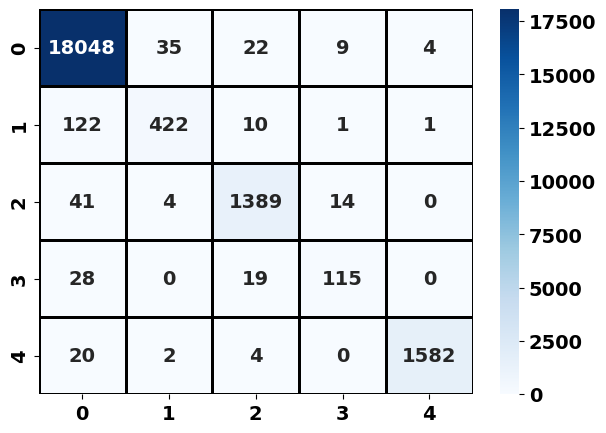

In [21]:
plt.figure(figsize = (7,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.savefig('Conf_mat.pdf', bbox_inches='tight')

In [22]:
from tensorflow.keras.models import save_model
# Generate generalization metrics
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Regular CNN - Test loss: {score[0]} / Test accuracy: {score[1]}')

# Store file
_, keras_file = tempfile.mkstemp('.h5')
save_model(model, keras_file, include_optimizer=False)
print(f'Baseline model saved: {keras_file}')

Regular CNN - Test loss: 0.06005548685789108 / Test accuracy: 0.9846519231796265
Baseline model saved: /tmp/tmppnhq1109.h5


<ipython-input-22-d6a54ff39dda>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, keras_file, include_optimizer=False)


In [23]:
model.save('ECG.h5',include_optimizer=False)

import os
# Get the size of the saved model file
saved_model_size = os.path.getsize('ECG.h5')
tempt_saved_model_size = os.path.getsize(keras_file)

# Print the size
print("Saved model size:", saved_model_size/1024, "kB")
print("Saved model size:",tempt_saved_model_size /1024, "kB")

Saved model size: 392.640625 kB
Saved model size: 392.640625 kB


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# Load functionality for adding pruning wrappers
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Finish pruning after 5 epochs
pruning_epochs = 5
num_images = input_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * pruning_epochs

In [25]:
# Define pruning configuration
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.40,
                                                               final_sparsity=0.70,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(model, **pruning_params)

In [26]:
# Recompile the model
model_for_pruning.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])

# Model callbacks
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]


In [27]:
# Fitting data
model_for_pruning.fit(input_train, target_train,
                      batch_size=batch_size,
                      epochs=pruning_epochs,
                      verbose=verbosity,
                      callbacks=callbacks,
                      validation_data=(input_test, target_test))

Epoch 1/5
438/438 [==============================] - 23s 27ms/step - loss: 0.0551 - accuracy: 0.9832 - val_loss: 0.0652 - val_accuracy: 0.9826
Epoch 2/5
438/438 [==============================] - 5s 11ms/step - loss: 0.0558 - accuracy: 0.9836 - val_loss: 0.0614 - val_accuracy: 0.9814
Epoch 3/5
438/438 [==============================] - 7s 15ms/step - loss: 0.0545 - accuracy: 0.9838 - val_loss: 0.0623 - val_accuracy: 0.9830
Epoch 4/5
438/438 [==============================] - 5s 11ms/step - loss: 0.0482 - accuracy: 0.9855 - val_loss: 0.0628 - val_accuracy: 0.9835
Epoch 5/5
438/438 [==============================] - 6s 14ms/step - loss: 0.0464 - accuracy: 0.9862 - val_loss: 0.0607 - val_accuracy: 0.9840


In [28]:
# Generate generalization metrics
score_pruned = model_for_pruning.evaluate(input_test, target_test, verbose=0)
print(f'Pruned CNN - Test loss: {score_pruned[0]} / Test accuracy: {score_pruned[1]}')
print(f'Regular CNN - Test loss: {score[0]} / Test accuracy: {score[1]}')

Pruned CNN - Test loss: 0.06066664308309555 / Test accuracy: 0.9840124249458313
Regular CNN - Test loss: 0.06005548685789108 / Test accuracy: 0.9846519231796265


In [29]:
# Export the model
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
_, pruned_keras_file = tempfile.mkstemp('.h5')
save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print(f'Pruned model saved: {pruned_keras_file}')

<ipython-input-29-b409ea252941>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Pruned model saved: /tmp/tmpdjm4a_q7.h5


In [30]:
def representative_datasets():
    xtest_rd = X_train.values*255
    for i in range(200):
        nxt = (xtest_rd[i])
        nxt = nxt.reshape(1,187,1)
        nxt = np.array(nxt)
        nxt = ((nxt/127.5)-1.0).astype(np.float32)
        yield([nxt])

In [32]:
'''Pre-Quantization'''
#tripped_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

#q_aware_model = tfmot.quantization.keras.quantize_annotate_model(model_for_pruning)

#quantize_model = tfmot.quantization.keras.quantize_model
#q_aware_model = quantize_model(tripped_model)
#q_aware_model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
#q_aware_model.fit(input_train, target_train, batch_size=200, epochs=10, validation_data=(input_test, target_test))

'Pre-Quantization'

****Signed 8-bit Quantization****

In [33]:
stripped_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
converter = tf.lite.TFLiteConverter.from_keras_model(stripped_model)

# Pass representative dataset to the converter
converter.representative_dataset = representative_datasets

# Set the optimization mode
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Restricting supported target op specification to INT8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert and Save the model
tflite_model = converter.convert()
open("EEG.tflite", "wb").write(tflite_model)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


110232

**Converting the Tflite model to C compatible array**

In [34]:
!xxd -i EEG.tflite > EEG.cc
#!cat EEG.cc

In [35]:
tflite_model_path = "EEG.tflite"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[  1 187   1]
[1 5]


In [36]:
nin = 600
nstrt = 20000

In [37]:
interpreter.resize_tensor_input(input_details[0]['index'], (nin, 187,1))
interpreter.resize_tensor_input(output_details[0]['index'], (nin, 5))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [600 187   1]
Input Type: <class 'numpy.int8'>
Output Shape: [600   5]
Output Type: <class 'numpy.int8'>


**Testing the converted model on few testing samples**

In [40]:
input_check = input_test[nstrt:(nstrt+nin)]
target_check = target_test[nstrt:(nstrt+nin),:]

In [41]:

test_imgs_numpy = np.array(input_check*127.5, dtype=np.int8)
test_sig = test_imgs_numpy.reshape(nin,187,1)

from time import time
t1 = time()
interpreter.set_tensor(input_details[0]['index'], test_sig)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print((time()-t1)/nin)
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

0.00021510521570841472
Prediction results shape: (600, 5)


In [42]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(prediction_classes, np.argmax(target_test[nstrt:(nstrt+nin),:],axis=1))

print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.9083333333333333
